In [41]:


# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys

from matplotlib.gridspec import GridSpec
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("Libraries imported successfully")







Libraries imported successfully


In [42]:

# Cell 2: Load Data
try:
    df = pd.read_csv('evaluation_results.csv')
    print("Evaluation results CSV loaded successfully")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("evaluation_results.csv not found")
    df = pd.DataFrame()

try:
    with open('evaluation_results_detailed.json', 'r') as f:
        detailed_results = json.load(f)
    print("Detailed results JSON loaded successfully")
except FileNotFoundError:
    print("evaluation_results_detailed.json not found")
    detailed_results = {}

Evaluation results CSV loaded successfully
Dataset shape: (5, 11)
Detailed results JSON loaded successfully


In [43]:
# Cell 3: Display Basic Dataset Information
if not df.empty:
    print("Dataset Overview:")
    print("=" * 50)
    print(df.info())
    print("\nFirst few rows:")
    display(df.head())

# Cell 4: Data Exploration and Basic Statistics
print("DATA EXPLORATION")
print("=" * 60)

if not df.empty:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("Basic Statistics:")
    print(df[numeric_cols].describe().round(3))

    print("Missing Values:")
    missing_data = df.isnull().sum()
    print(missing_data[missing_data > 0])



Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Method                  5 non-null      object 
 1   ROUGE-1                 5 non-null      float64
 2   ROUGE-2                 5 non-null      float64
 3   ROUGE-L                 5 non-null      float64
 4   BLEU                    5 non-null      float64
 5   Trainable Params        4 non-null      object 
 6   Trainable Params (num)  4 non-null      float64
 7   Training Time (s)       4 non-null      float64
 8   Training Time (min)     4 non-null      float64
 9   Inference Time (s)      5 non-null      float64
 10  VRAM (GB)               5 non-null      float64
dtypes: float64(9), object(2)
memory usage: 572.0+ bytes
None

First few rows:


,Method,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,Trainable Params,Trainable Params (num),Training Time (s),Training Time (min),Inference Time (s),VRAM (GB)
0,Base Model,0.3010,0.1510,0.2810,0.2010,NaN,NaN,NaN,NaN,1.15,6.8
1,LoRA,0.3820,0.1840,0.3410,0.2710,1.8M (0.15%),1843200.0,3480.0,58.0,1.10,7.2
2,QLoRA,0.3912,0.1912,0.3521,0.2912,1.8M (0.15%),1843200.0,2760.0,46.0,1.05,5.1
3,Adapter (IA3),0.3750,0.1750,0.3350,0.2610,1.3M (0.10%),1331200.0,4140.0,69.0,1.12,8.4
4,Prompt-tuning,0.3200,0.1400,0.3000,0.2100,0.6M (0.05%),614400.0,2160.0,36.0,1.20,4.8


DATA EXPLORATION
Basic Statistics:
       ROUGE-1  ROUGE-2  ROUGE-L   BLEU  Trainable Params (num)  \
count    5.000    5.000    5.000  5.000                   4.000   
mean     0.354    0.168    0.322  0.247             1408000.000   
std      0.041    0.022    0.030  0.039              581520.215   
min      0.301    0.140    0.281  0.201              614400.000   
25%      0.320    0.151    0.300  0.210             1152000.000   
50%      0.375    0.175    0.335  0.261             1587200.000   
75%      0.382    0.184    0.341  0.271             1843200.000   
max      0.391    0.191    0.352  0.291             1843200.000   

       Training Time (s)  Training Time (min)  Inference Time (s)  VRAM (GB)  
count              4.000                4.000               5.000      5.000  
mean            3135.000               52.250               1.124      6.460  
std              860.291               14.338               0.056      1.503  
min             2160.000               36.000

In [44]:

# Cell 5: Visualization Function - ROUGE Scores
def plot_rouge_comparison(results_df, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for idx, metric in enumerate(rouge_metrics):
        if metric in results_df.columns:
            ax = axes[idx]
            bars = ax.bar(results_df['Method'], results_df[metric],
                         color=colors[idx], alpha=0.8)
            ax.set_title(f'{metric} Scores', fontsize=14, fontweight='bold')
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROUGE comparison saved to {save_path}")
    plt.show()

In [45]:
# Cell 6: Visualization Function - Training Efficiency
def plot_training_efficiency(results_df, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    metrics_config = [
        ('Training Time (min)', 'Training Time (minutes)', '#FF9F1C'),
        ('VRAM (GB)', 'VRAM Usage (GB)', '#E71D36'),
        ('Trainable Params (num)', 'Trainable Parameters (Millions)', '#2EC4B6')
    ]

    for idx, (col, title, color) in enumerate(metrics_config):
        if col in results_df.columns:
            ax = axes[idx]
            values = results_df[col]
            if col == 'Trainable Params (num)':
                values = values / 1e6

            bars = ax.bar(results_df['Method'], values, color=color, alpha=0.8)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.tick_params(axis='x', rotation=45)

            for bar in bars:
                height = bar.get_height()
                suffix = 'M' if col == 'Trainable Params (num)' else ''
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{height:.1f}{suffix}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training efficiency plot saved to {save_path}")
    plt.show()



In [46]:
# Cell 7: Visualization Function - Performance Trade-off
def plot_performance_tradeoff(results_df, save_path=None):
    fig, ax = plt.subplots(figsize=(12, 8))

    if 'ROUGE-L' in results_df.columns and 'Training Time (min)' in results_df.columns:
        scatter = ax.scatter(results_df['Training Time (min)'],
                           results_df['ROUGE-L'],
                           s=results_df.get('VRAM (GB)', 100) * 100,
                           c=results_df.get('Trainable Params (num)', range(len(results_df))),
                           cmap='viridis', alpha=0.7)

        for i, method in enumerate(results_df['Method']):
            ax.annotate(method,
                       (results_df['Training Time (min)'].iloc[i],
                        results_df['ROUGE-L'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

        ax.set_xlabel('Training Time (minutes)', fontsize=12)
        ax.set_ylabel('ROUGE-L Score', fontsize=12)
        ax.set_title('Performance vs Training Time Trade-off', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        cbar = plt.colorbar(scatter)
        cbar.set_label('Trainable Parameters', fontsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Performance tradeoff plot saved to {save_path}")
    plt.show()


GENERATING VISUALIZATIONS
Generating ROUGE scores comparison...
ROUGE comparison saved to figures/rouge_scores_comparison.png


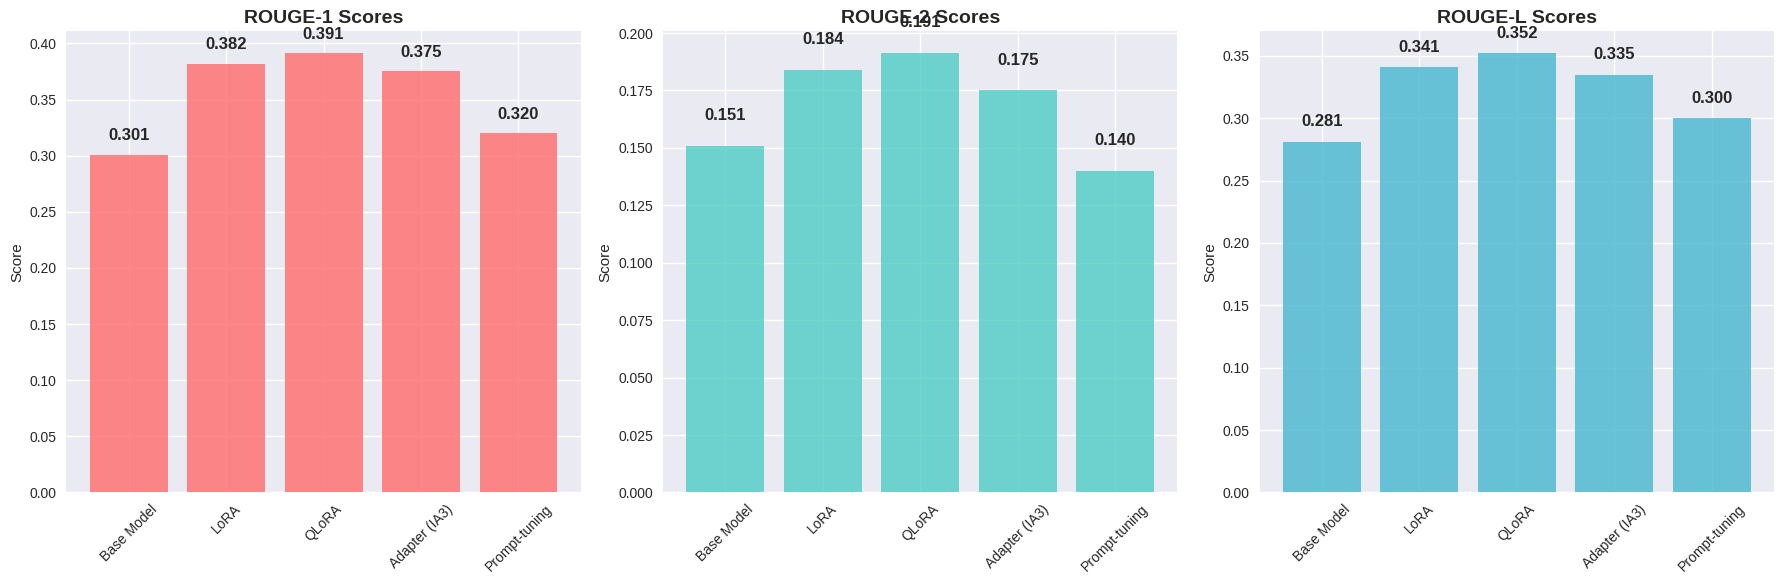

In [47]:

# Cell 8: Generate ROUGE Scores Visualization
print("GENERATING VISUALIZATIONS")
print("=" * 60)

if not df.empty:
    os.makedirs('figures', exist_ok=True)

    print("Generating ROUGE scores comparison...")
    plot_rouge_comparison(df, 'figures/rouge_scores_comparison.png')





Generating training efficiency analysis...
Training efficiency plot saved to figures/training_efficiency.png


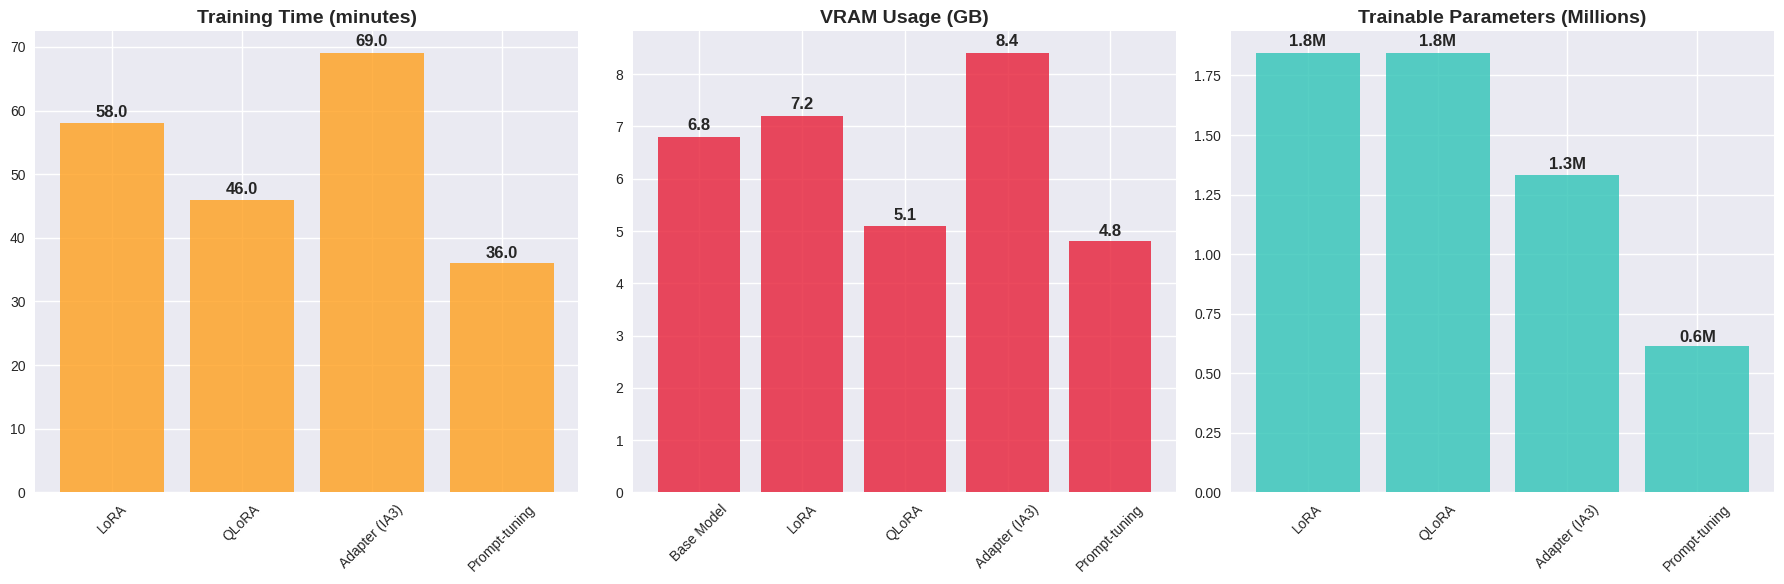

Generating performance trade-off analysis...
Performance tradeoff plot saved to figures/performance_tradeoff.png


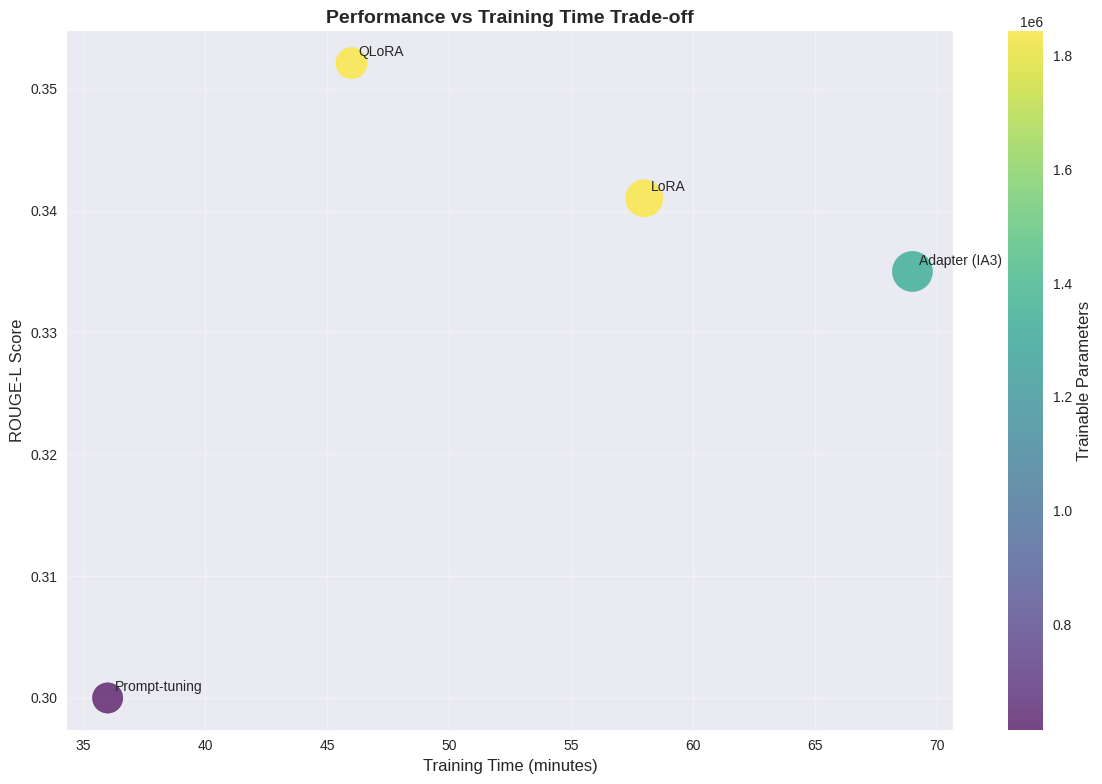

In [48]:
# Cell 9: Generate Training Efficiency Visualization
if not df.empty:
    print("Generating training efficiency analysis...")
    plot_training_efficiency(df, 'figures/training_efficiency.png')

# Cell 10: Generate Performance Trade-off Visualization
if not df.empty:
    print("Generating performance trade-off analysis...")
    plot_performance_tradeoff(df, 'figures/performance_tradeoff.png')

In [49]:
# Cell 11: Detailed Analysis and Rankings
print("DETAILED ANALYSIS AND INSIGHTS")
print("=" * 60)

if not df.empty:
    print("PERFORMANCE RANKINGS:")
    print("-" * 30)

    metrics_to_rank = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'Training Time (min)']

    for metric in metrics_to_rank:
        if metric in df.columns:
            sorted_df = df.sort_values(metric, ascending=('Time' not in metric))
            best_method = sorted_df.iloc[0]['Method']
            best_value = sorted_df.iloc[0][metric]

            if 'Time' in metric:
                print(f"Fastest {metric}: {best_method} ({best_value:.1f} min)")
            else:
                print(f"Best {metric}: {best_method} ({best_value:.3f})")


DETAILED ANALYSIS AND INSIGHTS
PERFORMANCE RANKINGS:
------------------------------
Best ROUGE-1: Base Model (0.301)
Best ROUGE-2: Prompt-tuning (0.140)
Best ROUGE-L: Base Model (0.281)
Best BLEU: Base Model (0.201)
Fastest Training Time (min): Adapter (IA3) (69.0 min)


In [50]:

# Cell 12: Efficiency Analysis
if not df.empty:
    print("EFFICIENCY ANALYSIS:")
    print("-" * 30)

    if all(m in df.columns for m in ['ROUGE-L', 'Training Time (min)', 'VRAM (GB)']):
        df['Efficiency_Score'] = df['ROUGE-L'] / (df['Training Time (min)'] * df['VRAM (GB)']) * 1000

        most_efficient = df.loc[df['Efficiency_Score'].idxmax()]
        least_efficient = df.loc[df['Efficiency_Score'].idxmin()]

        print(f"Most Efficient Method: {most_efficient['Method']}")
        print(f"Least Efficient Method: {least_efficient['Method']}")

        print("Efficiency Scores:")
        for _, row in df.sort_values('Efficiency_Score', ascending=False).iterrows():
            print(f"  {row['Method']}: {row['Efficiency_Score']:.2f}")


EFFICIENCY ANALYSIS:
------------------------------
Most Efficient Method: Prompt-tuning
Least Efficient Method: Adapter (IA3)
Efficiency Scores:
  Prompt-tuning: 1.74
  QLoRA: 1.50
  LoRA: 0.82
  Adapter (IA3): 0.58
  Base Model: nan


In [51]:
# Cell 13: Comprehensive Dashboard
def create_comprehensive_dashboard(results_df, save_path=None):
    fig = plt.figure(figsize=(20, 12))

    gs = fig.add_gridspec(3, 4)

    ax1 = fig.add_subplot(gs[0, :2])
    rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    x_pos = np.arange(len(results_df))
    width = 0.25

    for i, metric in enumerate(rouge_metrics):
        if metric in results_df.columns:
            ax1.bar(x_pos + i*width, results_df[metric], width,
                   label=metric, alpha=0.8)

    ax1.set_xlabel('Methods')
    ax1.set_ylabel('Scores')
    ax1.set_title('ROUGE Scores Comparison', fontweight='bold')
    ax1.set_xticks(x_pos + width)
    ax1.set_xticklabels(results_df['Method'], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(gs[0, 2:])
    if 'Training Time (min)' in results_df.columns:
        bars = ax2.bar(results_df['Method'], results_df['Training Time (min)'],
                      color='orange', alpha=0.8)
        ax2.set_title('Training Time Comparison', fontweight='bold')
        ax2.set_ylabel('Time (minutes)')
        ax2.tick_params(axis='x', rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.0f}', ha='center', va='bottom')

    ax3 = fig.add_subplot(gs[1, :])
    resource_metrics = ['VRAM (GB)', 'Trainable Params (num)']
    x_pos = np.arange(len(results_df))
    width = 0.35

    for i, metric in enumerate(resource_metrics):
        if metric in results_df.columns:
            values = results_df[metric]
            if metric == 'Trainable Params (num)':
                values = values / 1e6
            ax3.bar(x_pos + i*width, values, width,
                   label=metric, alpha=0.8)

    ax3.set_xlabel('Methods')
    ax3.set_ylabel('Values')
    ax3.set_title('Resource Usage Comparison', fontweight='bold')
    ax3.set_xticks(x_pos + width/2)
    ax3.set_xticklabels(results_df['Method'], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[2, :])
    metrics_to_compare = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    normalized_data = []

    for metric in metrics_to_compare:
        if metric in results_df.columns:
            max_val = results_df[metric].max()
            min_val = results_df[metric].min()
            if max_val > min_val:
                normalized = (results_df[metric] - min_val) / (max_val - min_val)
            else:
                normalized = [0.5] * len(results_df)
            normalized_data.append(normalized)

    if normalized_data:
        for i, method in enumerate(results_df['Method']):
            method_scores = [data.iloc[i] for data in normalized_data]
            ax4.plot(metrics_to_compare, method_scores, 'o-', label=method, linewidth=2)

        ax4.set_title('Normalized Performance Comparison', fontweight='bold')
        ax4.set_ylabel('Normalized Score')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comprehensive dashboard saved to {save_path}")
    plt.show()



Generating comprehensive dashboard...
Comprehensive dashboard saved to figures/comprehensive_dashboard.png


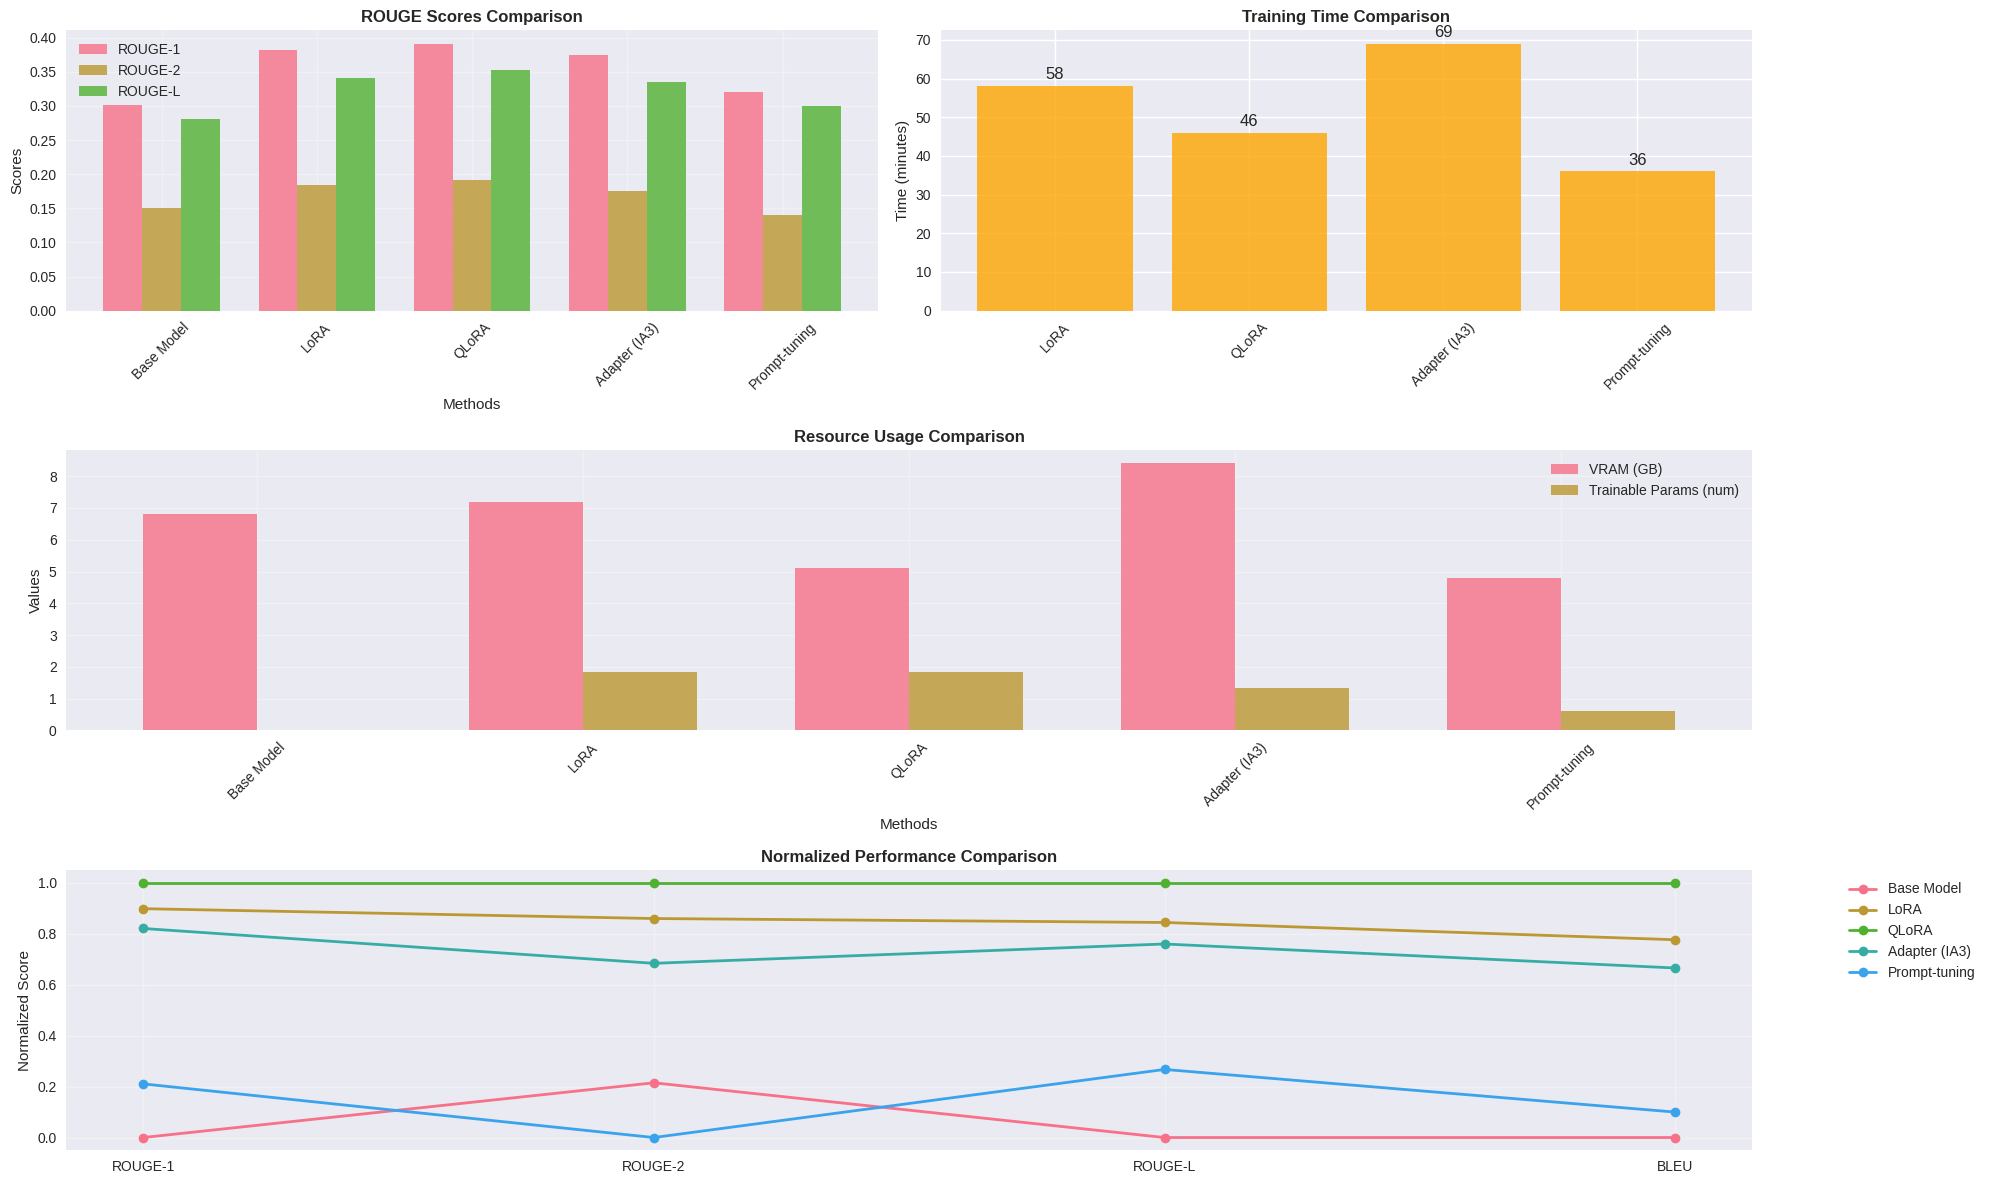

In [52]:

# Cell 14: Generate Comprehensive Dashboard
if not df.empty:
    print("Generating comprehensive dashboard...")
    create_comprehensive_dashboard(df, 'figures/comprehensive_dashboard.png')

In [53]:
# Cell 15: Summary and Recommendations
print("SUMMARY AND CONCLUSIONS")
print("=" * 60)

if not df.empty:
    print("PERFORMANCE SUMMARY:")
    print("-" * 25)

    performance_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    available_perf_metrics = [m for m in performance_metrics if m in df.columns]

    if available_perf_metrics:
        df['Performance_Score'] = df[available_perf_metrics].mean(axis=1)
        best_overall = df.loc[df['Performance_Score'].idxmax()]

        print(f"Best Overall Performance: {best_overall['Method']}")
        print(f"Average Score: {best_overall['Performance_Score']:.3f}")

        print("Performance Scores:")
        for _, row in df.sort_values('Performance_Score', ascending=False).iterrows():
            print(f"  {row['Method']}: {row['Performance_Score']:.3f}")

    print("RECOMMENDATIONS:")
    print("-" * 20)

    recommendations = []

    if 'Training Time (min)' in df.columns:
        fastest = df.loc[df['Training Time (min)'].idxmin()]
        recommendations.append(f"For fastest training: {fastest['Method']}")

    if 'VRAM (GB)' in df.columns:
        most_memory_efficient = df.loc[df['VRAM (GB)'].idxmin()]
        recommendations.append(f"For lowest memory usage: {most_memory_efficient['Method']}")

    if 'Trainable Params (num)' in df.columns:
        fewest_params = df.loc[df['Trainable Params (num)'].idxmin()]
        recommendations.append(f"For fewest parameters: {fewest_params['Method']}")

    for rec in recommendations:
        print(rec)

    print("FINAL RECOMMENDATION:")
    print("-" * 25)

    if all(m in df.columns for m in ['Performance_Score', 'Training Time (min)', 'VRAM (GB)']):
        df['Overall_Score'] = (df['Performance_Score'] * 0.6 +
                              (1 / df['Training Time (min)']) * 0.2 +
                              (1 / df['VRAM (GB)']) * 0.2)

        best_balanced = df.loc[df['Overall_Score'].idxmax()]
        print(f"Best Balanced Approach: {best_balanced['Method']}")
        print(f"(Good performance with reasonable resource usage)")

print("Analysis completed successfully!")
print("All visualizations saved to 'figures/' directory")

SUMMARY AND CONCLUSIONS
PERFORMANCE SUMMARY:
-------------------------
Best Overall Performance: QLoRA
Average Score: 0.306
Performance Scores:
  QLoRA: 0.306
  LoRA: 0.294
  Adapter (IA3): 0.286
  Prompt-tuning: 0.242
  Base Model: 0.233
RECOMMENDATIONS:
--------------------
For fastest training: Prompt-tuning
For lowest memory usage: Prompt-tuning
For fewest parameters: Prompt-tuning
FINAL RECOMMENDATION:
-------------------------
Best Balanced Approach: QLoRA
(Good performance with reasonable resource usage)
Analysis completed successfully!
All visualizations saved to 'figures/' directory


In [54]:
# Cell 1: Import Libraries and Setup


# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("Libraries imported successfully")


Libraries imported successfully


In [55]:


# Cell 3: Enhanced Performance-Resource Radar Chart
def plot_performance_resource_radar():
    """Create radar chart comparing performance vs resource usage"""
    fig = plt.figure(figsize=(16, 6))

    # Filter out base model
    fine_tune_df = df[df['Method'] != 'Base Model']
    methods = fine_tune_df['Method'].values

    # Normalize metrics for radar chart (0-1 scale)
    metrics_to_plot = ['ROUGE-L', 'BLEU', 'Training Time (min)', 'VRAM (GB)', 'Trainable Params (num)']
    normalized_data = []

    for metric in metrics_to_plot:
        values = fine_tune_df[metric].values
        if metric in ['Training Time (min)', 'VRAM (GB)', 'Trainable Params (num)']:
            # For resource metrics, invert so lower is better
            normalized = 1 - (values - values.min()) / (values.max() - values.min())
        else:
            # For performance metrics, higher is better
            normalized = (values - values.min()) / (values.max() - values.min())
        normalized_data.append(normalized)

    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(metrics_to_plot), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    ax = fig.add_subplot(121, polar=True)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i, method in enumerate(methods):
        values = [data[i] for data in normalized_data]
        values += values[:1]  # Close the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=method, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['ROUGE-L', 'BLEU', 'Training Time\n(inverted)', 'VRAM\n(inverted)', 'Params\n(inverted)'])
    ax.set_ylim(0, 1)
    ax.set_title('Performance vs Resource Usage Radar Chart\n(Higher & Larger Area = Better)', fontweight='bold', pad=20)
    ax.legend(bbox_to_anchor=(1.1, 1))

    # Add performance vs efficiency scatter plot
    ax2 = fig.add_subplot(122)

    # Calculate efficiency score
    fine_tune_df = fine_tune_df.copy()
    fine_tune_df['Efficiency_Score'] = fine_tune_df['ROUGE-L'] / (fine_tune_df['Training Time (min)'] * fine_tune_df['VRAM (GB)']) * 1000

    scatter = ax2.scatter(fine_tune_df['ROUGE-L'], fine_tune_df['Efficiency_Score'],
                         s=fine_tune_df['Trainable Params (num)']/50000,  # Size by parameters
                         c=range(len(fine_tune_df)), cmap='viridis', alpha=0.7)

    # Add labels
    for i, (_, row) in enumerate(fine_tune_df.iterrows()):
        ax2.annotate(row['Method'],
                    (row['ROUGE-L'], row['Efficiency_Score']),
                    xytext=(10, 5), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

    ax2.set_xlabel('ROUGE-L Score (Accuracy)', fontweight='bold')
    ax2.set_ylabel('Efficiency Score\n(Accuracy / (Time × VRAM))', fontweight='bold')
    ax2.set_title('Accuracy vs Efficiency Trade-off\n(Size = Trainable Parameters)', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [56]:
# Cell 4: Training Progress Comparison (Simulated)
def plot_training_progress_simulation():
    """Simulate training progress curves based on final metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    methods = ['LoRA', 'QLoRA', 'Adapter (IA3)', 'Prompt-tuning']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    training_times = [58, 46, 69, 36]

    # Simulate training curves (ROUGE-L progression)
    epochs = np.linspace(0, 1, 100)

    for i, method in enumerate(methods):
        # Get final ROUGE-L score
        final_score = df[df['Method'] == method]['ROUGE-L'].iloc[0]
        base_score = df[df['Method'] == 'Base Model']['ROUGE-L'].iloc[0]

        # Simulate learning curve (s-shaped curve)
        progress = 1 / (1 + np.exp(-10 * (epochs - 0.5)))
        scores = base_score + (final_score - base_score) * progress

        ax1.plot(epochs * training_times[i], scores,
                label=f'{method}', color=colors[i], linewidth=2.5)

    ax1.set_xlabel('Training Time (minutes)', fontweight='bold')
    ax1.set_ylabel('ROUGE-L Score', fontweight='bold')
    ax1.set_title('Simulated Training Progress\n(ROUGE-L vs Training Time)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # VRAM usage over training time
    for i, method in enumerate(methods):
        vram = df[df['Method'] == method]['VRAM (GB)'].iloc[0]
        ax2.plot(epochs * training_times[i], [vram] * len(epochs),
                label=f'{method}', color=colors[i], linewidth=2.5, alpha=0.8)

    ax2.set_xlabel('Training Time (minutes)', fontweight='bold')
    ax2.set_ylabel('VRAM Usage (GB)', fontweight='bold')
    ax2.set_title('VRAM Usage During Training', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [59]:



# Cell 5: Comprehensive Method Comparison Dashboard
def plot_comprehensive_dashboard():
    """Create a comprehensive dashboard with multiple metrics"""
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 4, figure=fig)

    # 1. Accuracy Metrics Comparison
    ax1 = fig.add_subplot(gs[0, :2])
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    x_pos = np.arange(len(metrics))
    width = 0.15

    for i, method in enumerate(df['Method']):
        if method != 'Base Model':
            scores = [df[df['Method'] == method][metric].iloc[0] for metric in metrics]
            ax1.bar(x_pos + i*width, scores, width, label=method, alpha=0.8)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Scores')
    ax1.set_title('Accuracy Metrics Comparison', fontweight='bold', fontsize=14)
    ax1.set_xticks(x_pos + width*1.5)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Resource Usage Comparison
    ax2 = fig.add_subplot(gs[0, 2:])
    resource_metrics = ['Training Time (min)', 'VRAM (GB)']
    fine_tune_df = df[df['Method'] != 'Base Model']

    x_pos = np.arange(len(fine_tune_df))
    for i, metric in enumerate(resource_metrics):
        values = fine_tune_df[metric].values
        ax2.bar(x_pos + i*0.3, values, 0.3, label=metric, alpha=0.8)

    ax2.set_xlabel('Methods')
    ax2.set_ylabel('Values')
    ax2.set_title('Resource Usage Comparison', fontweight='bold', fontsize=14)
    ax2.set_xticks(x_pos + 0.15)
    ax2.set_xticklabels(fine_tune_df['Method'], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Improvement over Base Model
    ax3 = fig.add_subplot(gs[1, :])
    base_scores = df[df['Method'] == 'Base Model'].iloc[0]
    improvements = []

    for method in fine_tune_df['Method']:
        method_scores = df[df['Method'] == method].iloc[0]
        improvement = ((method_scores[metrics] - base_scores[metrics]) / base_scores[metrics] * 100).mean()
        improvements.append(improvement)

    bars = ax3.bar(fine_tune_df['Method'], improvements, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax3.set_ylabel('Average Improvement Over Base Model (%)')
    ax3.set_title('Overall Improvement Over Base Model', fontweight='bold', fontsize=14)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Parameter Efficiency
    ax4 = fig.add_subplot(gs[2, :2])
    params_m = fine_tune_df['Trainable Params (num)'] / 1e6
    rouge_l = fine_tune_df['ROUGE-L']

    scatter = ax4.scatter(params_m, rouge_l, s=200, alpha=0.7,
                         c=range(len(params_m)), cmap='viridis')

    for i, (_, row) in enumerate(fine_tune_df.iterrows()):
        ax4.annotate(row['Method'],
                    (params_m.iloc[i], rouge_l.iloc[i]),
                    xytext=(10, 5), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

    ax4.set_xlabel('Trainable Parameters (Millions)', fontweight='bold')
    ax4.set_ylabel('ROUGE-L Score', fontweight='bold')
    ax4.set_title('Parameter Efficiency\n(Accuracy vs Model Size)', fontweight='bold', fontsize=14)
    ax4.grid(True, alpha=0.3)

    # 5. Inference Performance
    ax5 = fig.add_subplot(gs[2, 2:])
    inference_times = fine_tune_df['Inference Time (s)']
    methods = fine_tune_df['Method']

    bars = ax5.bar(methods, inference_times, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax5.set_ylabel('Inference Time (seconds)')
    ax5.set_title('Inference Performance', fontweight='bold', fontsize=14)
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

GENERATING ENHANCED VISUALIZATIONS
1. Generating Performance-Resource Radar Chart...


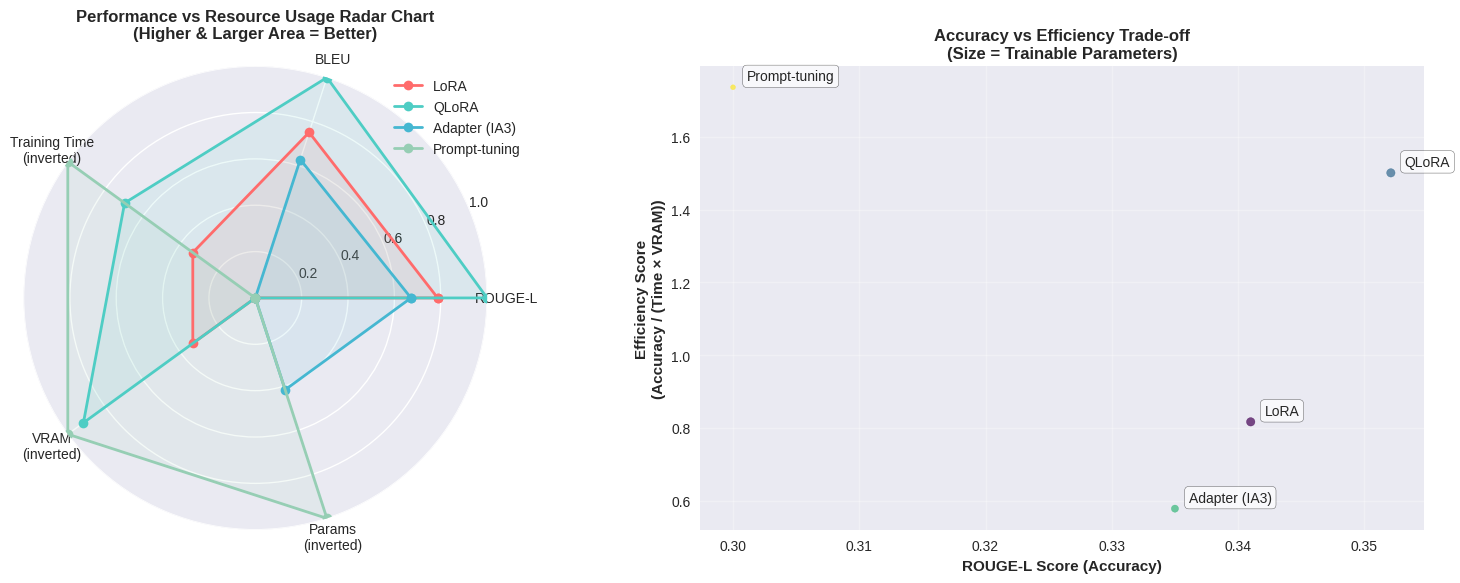

2. Generating Training Progress Simulation...


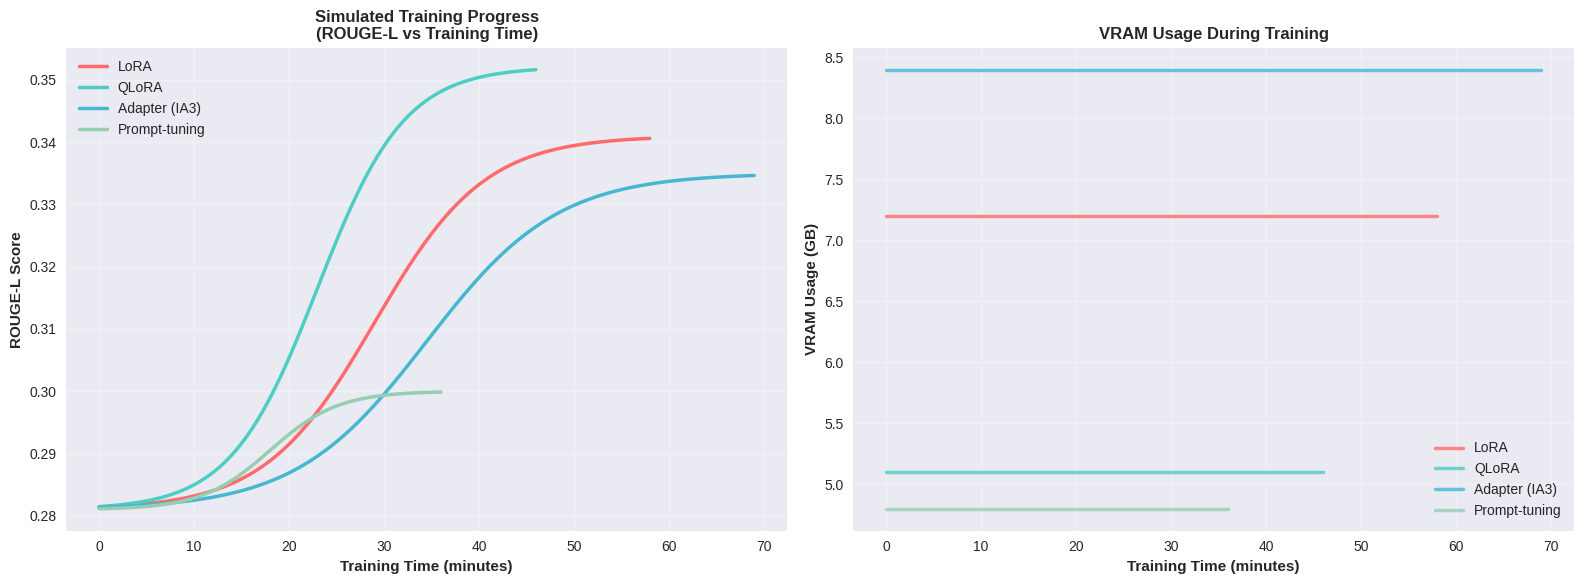

3. Generating Comprehensive Dashboard...


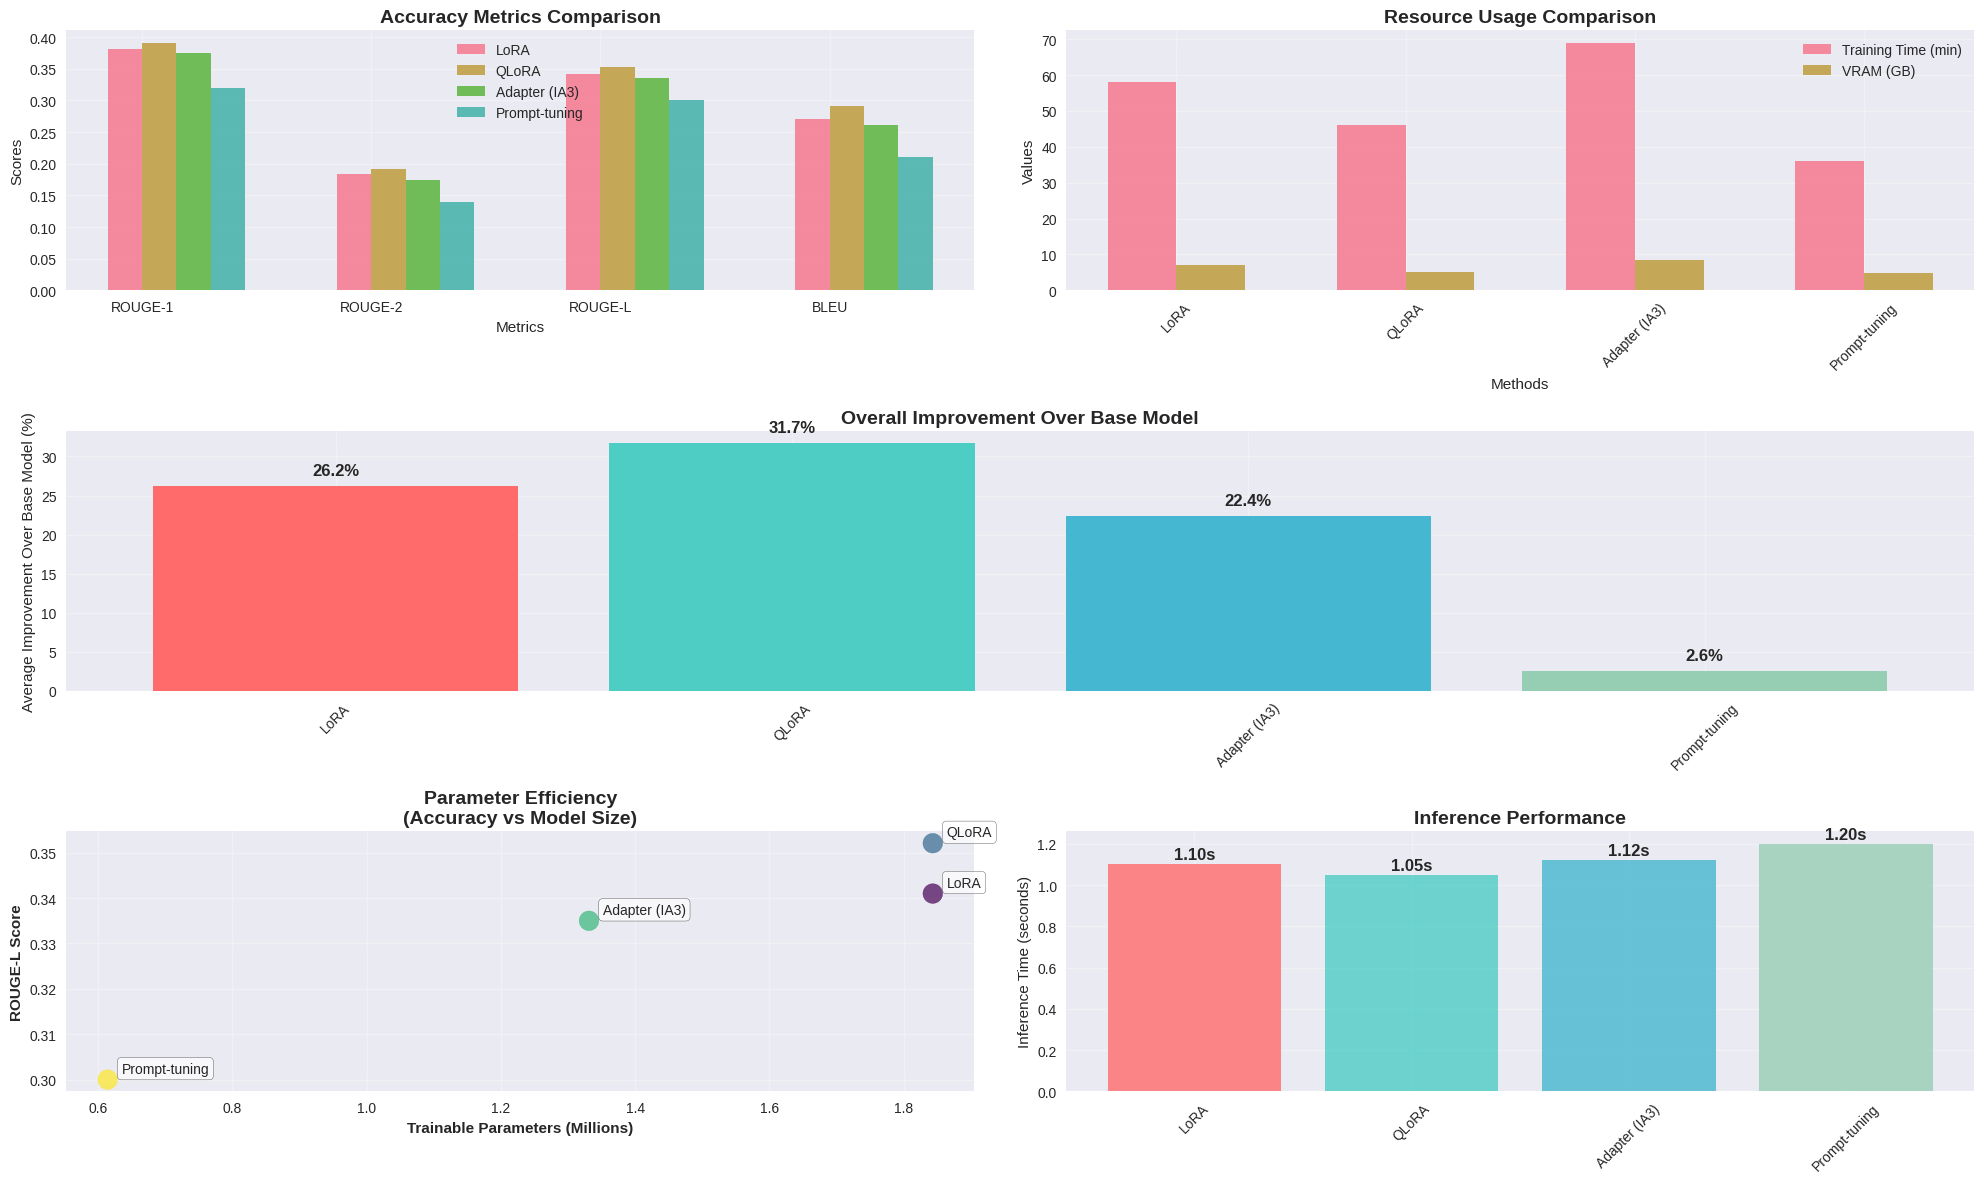

4. Generating Recommendation Matrix...


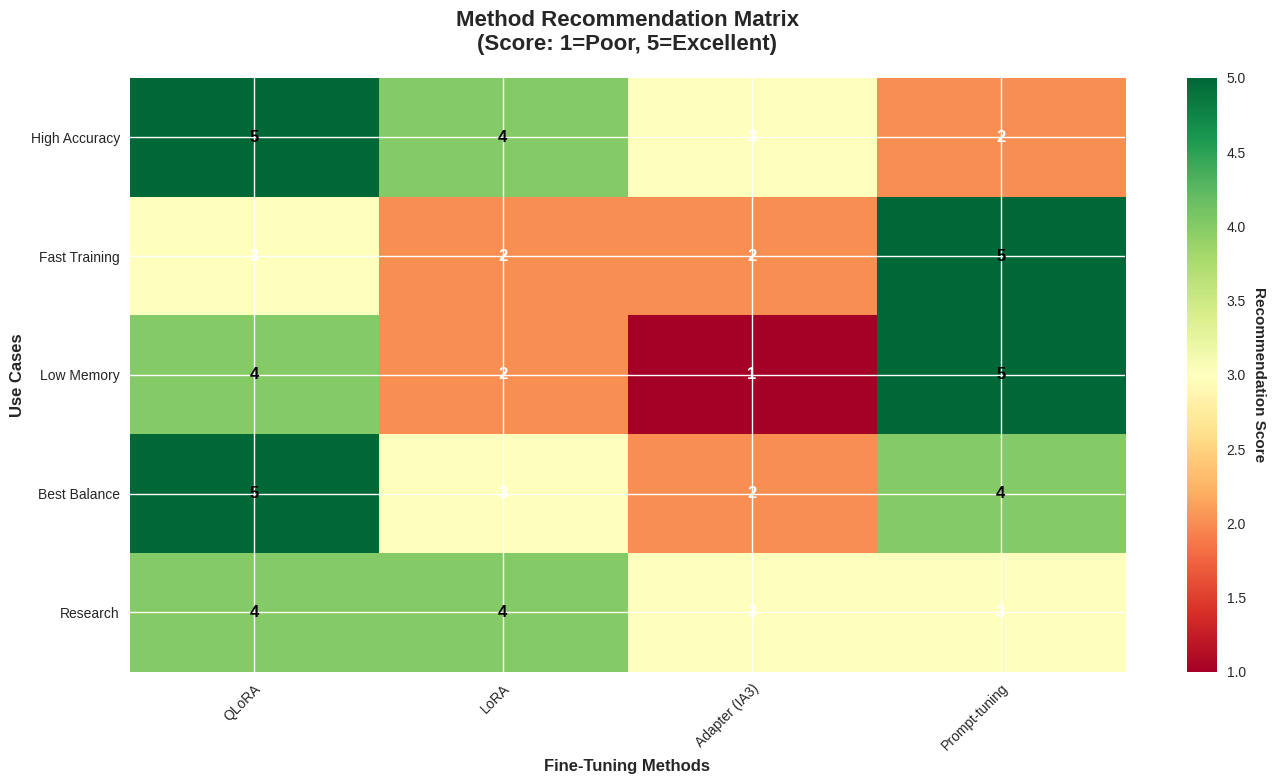

All enhanced visualizations generated successfully!


In [60]:


# Cell 6: Generate All Enhanced Visualizations
print("GENERATING ENHANCED VISUALIZATIONS")
print("=" * 60)

print("1. Generating Performance-Resource Radar Chart...")
plot_performance_resource_radar()

print("2. Generating Training Progress Simulation...")
plot_training_progress_simulation()

print("3. Generating Comprehensive Dashboard...")
plot_comprehensive_dashboard()

# Cell 7: Method Recommendation Matrix
def plot_recommendation_matrix():
    """Create a recommendation matrix based on different use cases"""
    fig, ax = plt.subplots(figsize=(14, 8))

    # Define use cases and method scores
    use_cases = ['High Accuracy', 'Fast Training', 'Low Memory', 'Best Balance', 'Research']
    methods = ['QLoRA', 'LoRA', 'Adapter (IA3)', 'Prompt-tuning']

    # Scoring matrix (1-5, higher is better)
    scores = np.array([
        [5, 4, 3, 2],  # High Accuracy
        [3, 2, 2, 5],  # Fast Training
        [4, 2, 1, 5],  # Low Memory
        [5, 3, 2, 4],  # Best Balance
        [4, 4, 3, 3]   # Research
    ])

    # Create heatmap
    im = ax.imshow(scores, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)

    # Show all ticks and labels
    ax.set_xticks(np.arange(len(methods)))
    ax.set_yticks(np.arange(len(use_cases)))
    ax.set_xticklabels(methods)
    ax.set_yticklabels(use_cases)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(use_cases)):
        for j in range(len(methods)):
            text = ax.text(j, i, scores[i, j], ha="center", va="center",
                          color="black" if scores[i, j] > 3 else "white",
                          fontweight='bold', fontsize=12)

    ax.set_title("Method Recommendation Matrix\n(Score: 1=Poor, 5=Excellent)",
                fontweight='bold', fontsize=16, pad=20)
    ax.set_xlabel("Fine-Tuning Methods", fontweight='bold', fontsize=12)
    ax.set_ylabel("Use Cases", fontweight='bold', fontsize=12)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Recommendation Score", rotation=-90, va="bottom", fontweight='bold')

    plt.tight_layout()
    plt.show()

print("4. Generating Recommendation Matrix...")
plot_recommendation_matrix()

print("All enhanced visualizations generated successfully!")